In [64]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel
from sklearn.model_selection import KFold
import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.integrate import quad
from astropy.constants import c
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV

plt.rc('text', usetex=True)  # Abilita l'uso di LaTeX in tutte le stringhe di testo
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'


# Data Driven part
First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

(35.0, 50.0)

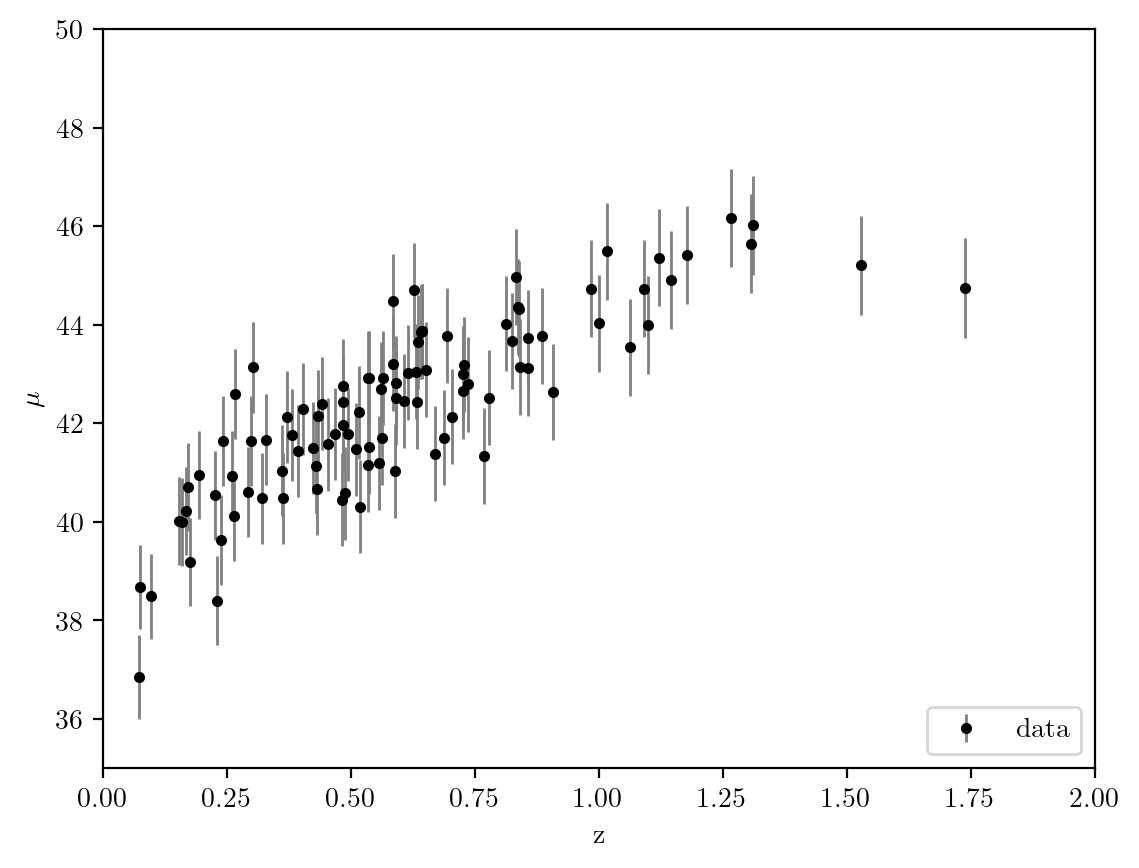

In [68]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

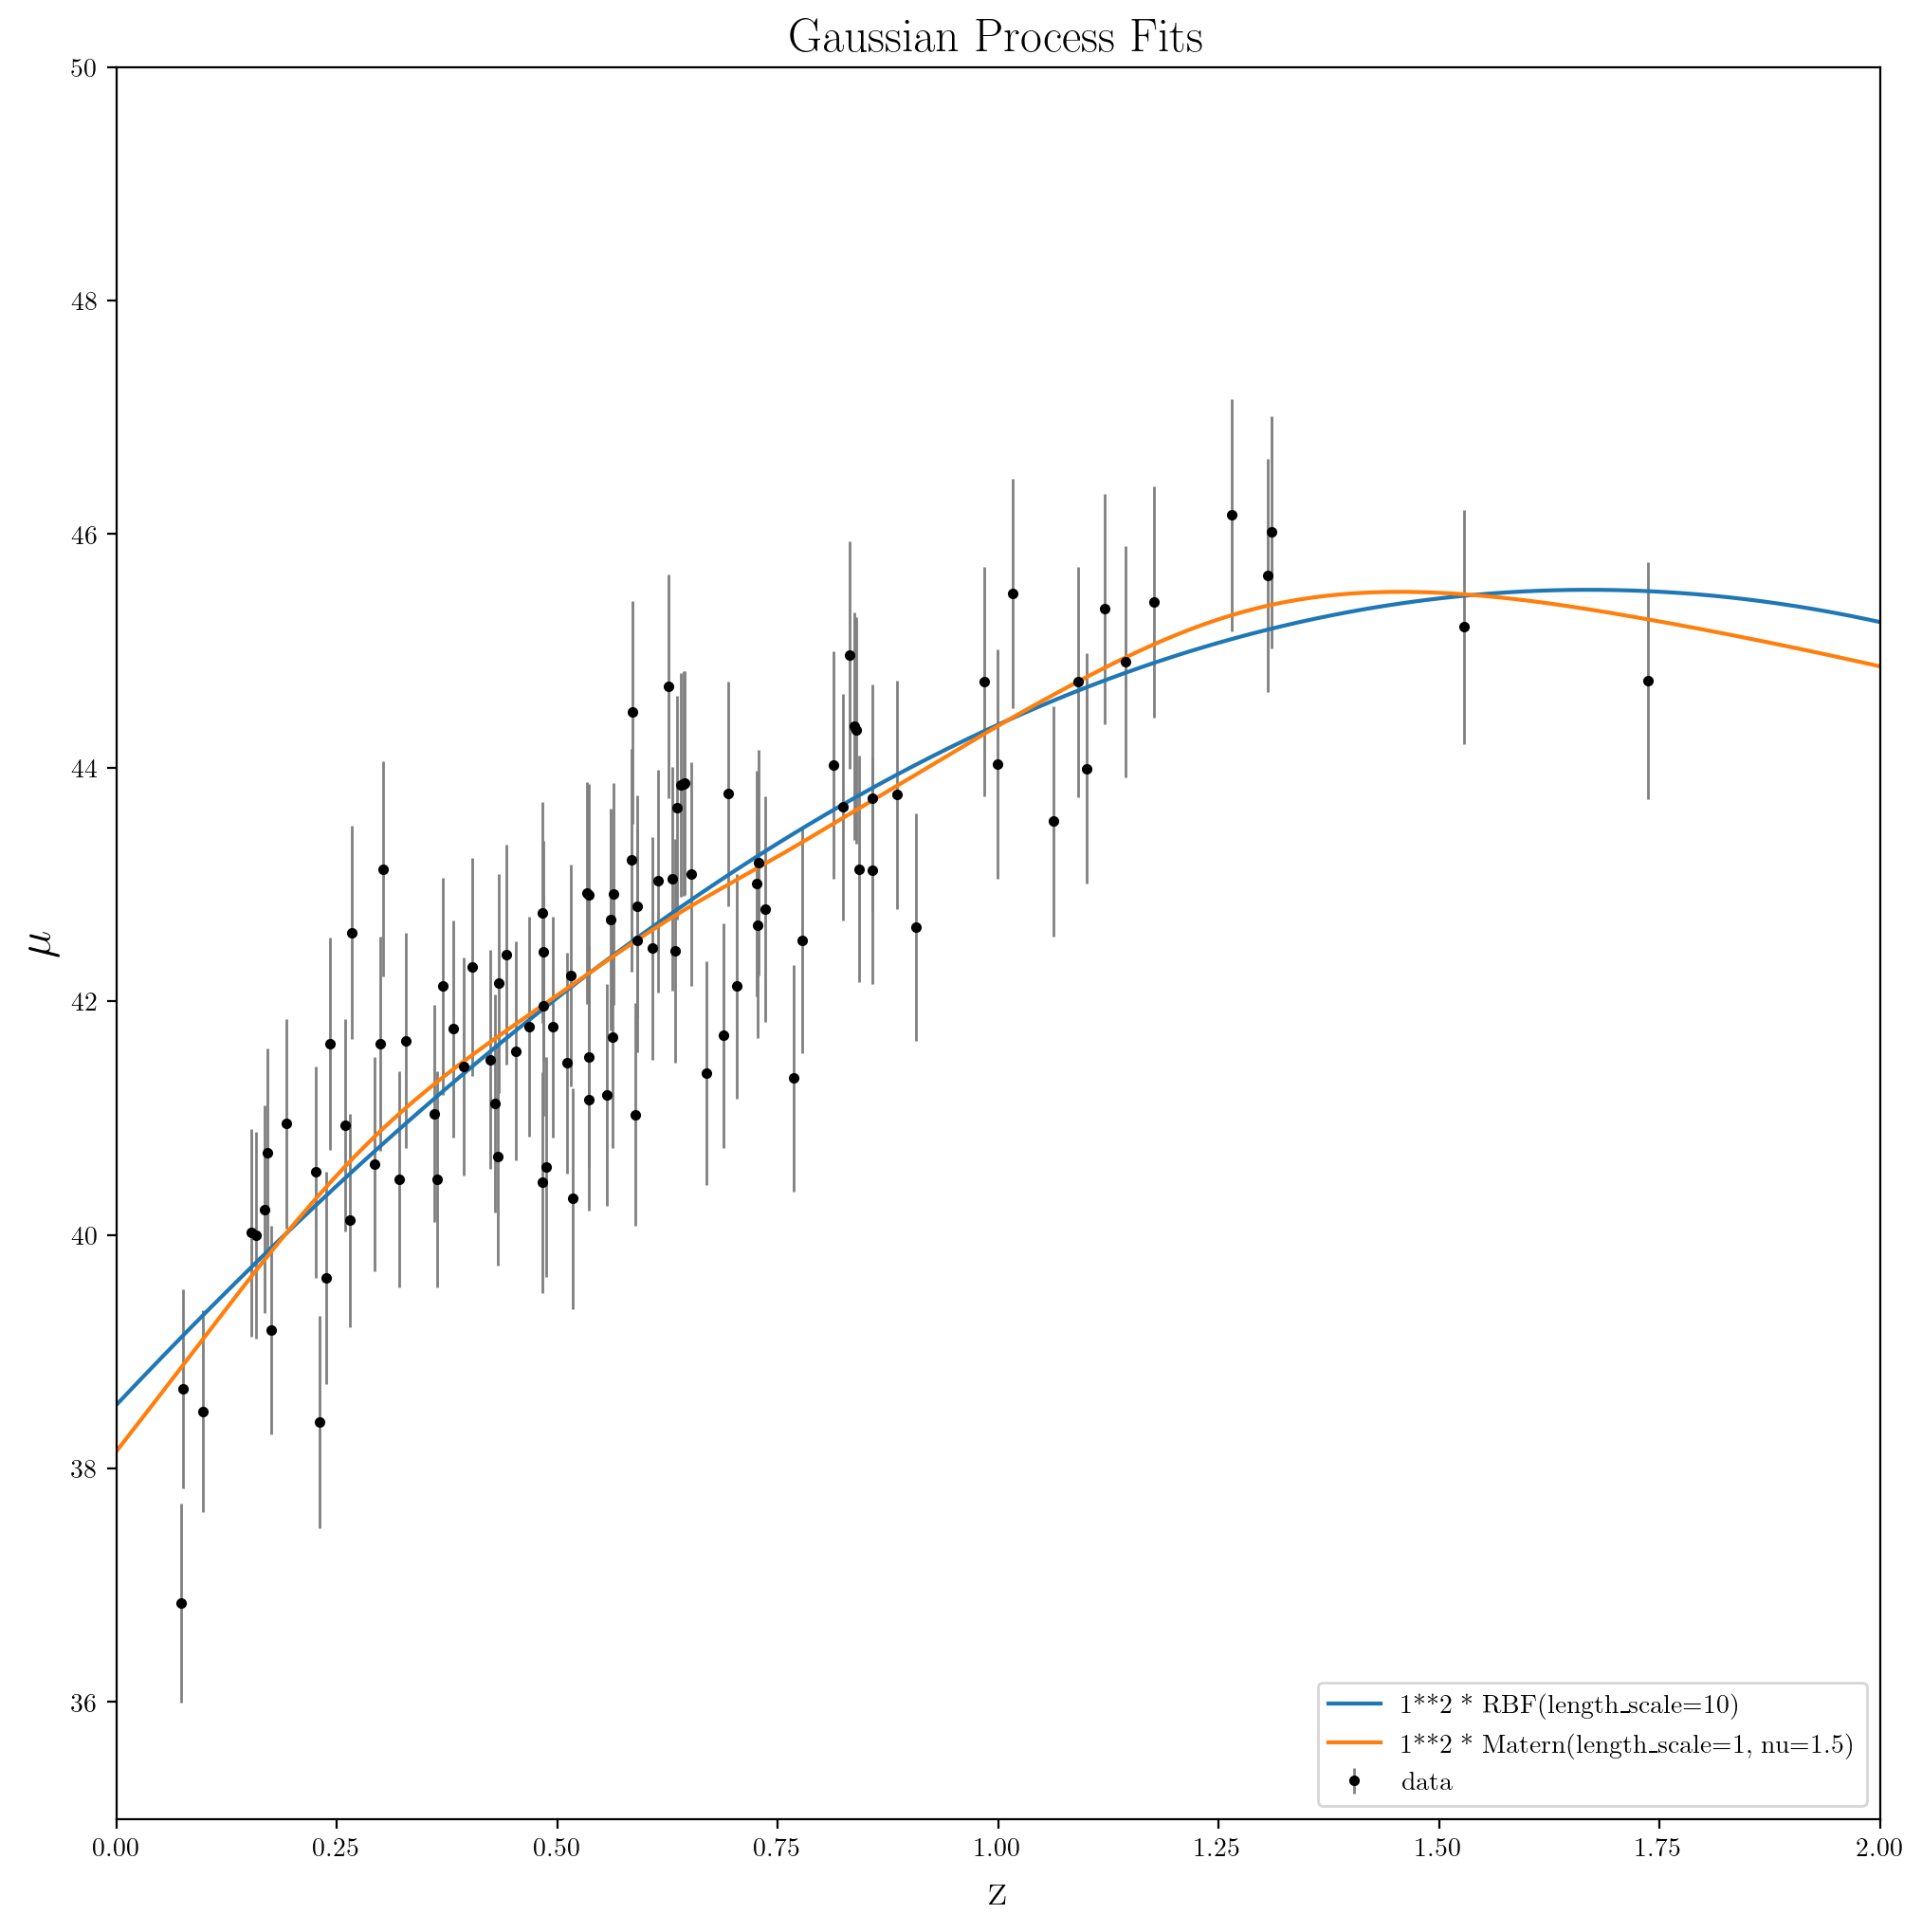

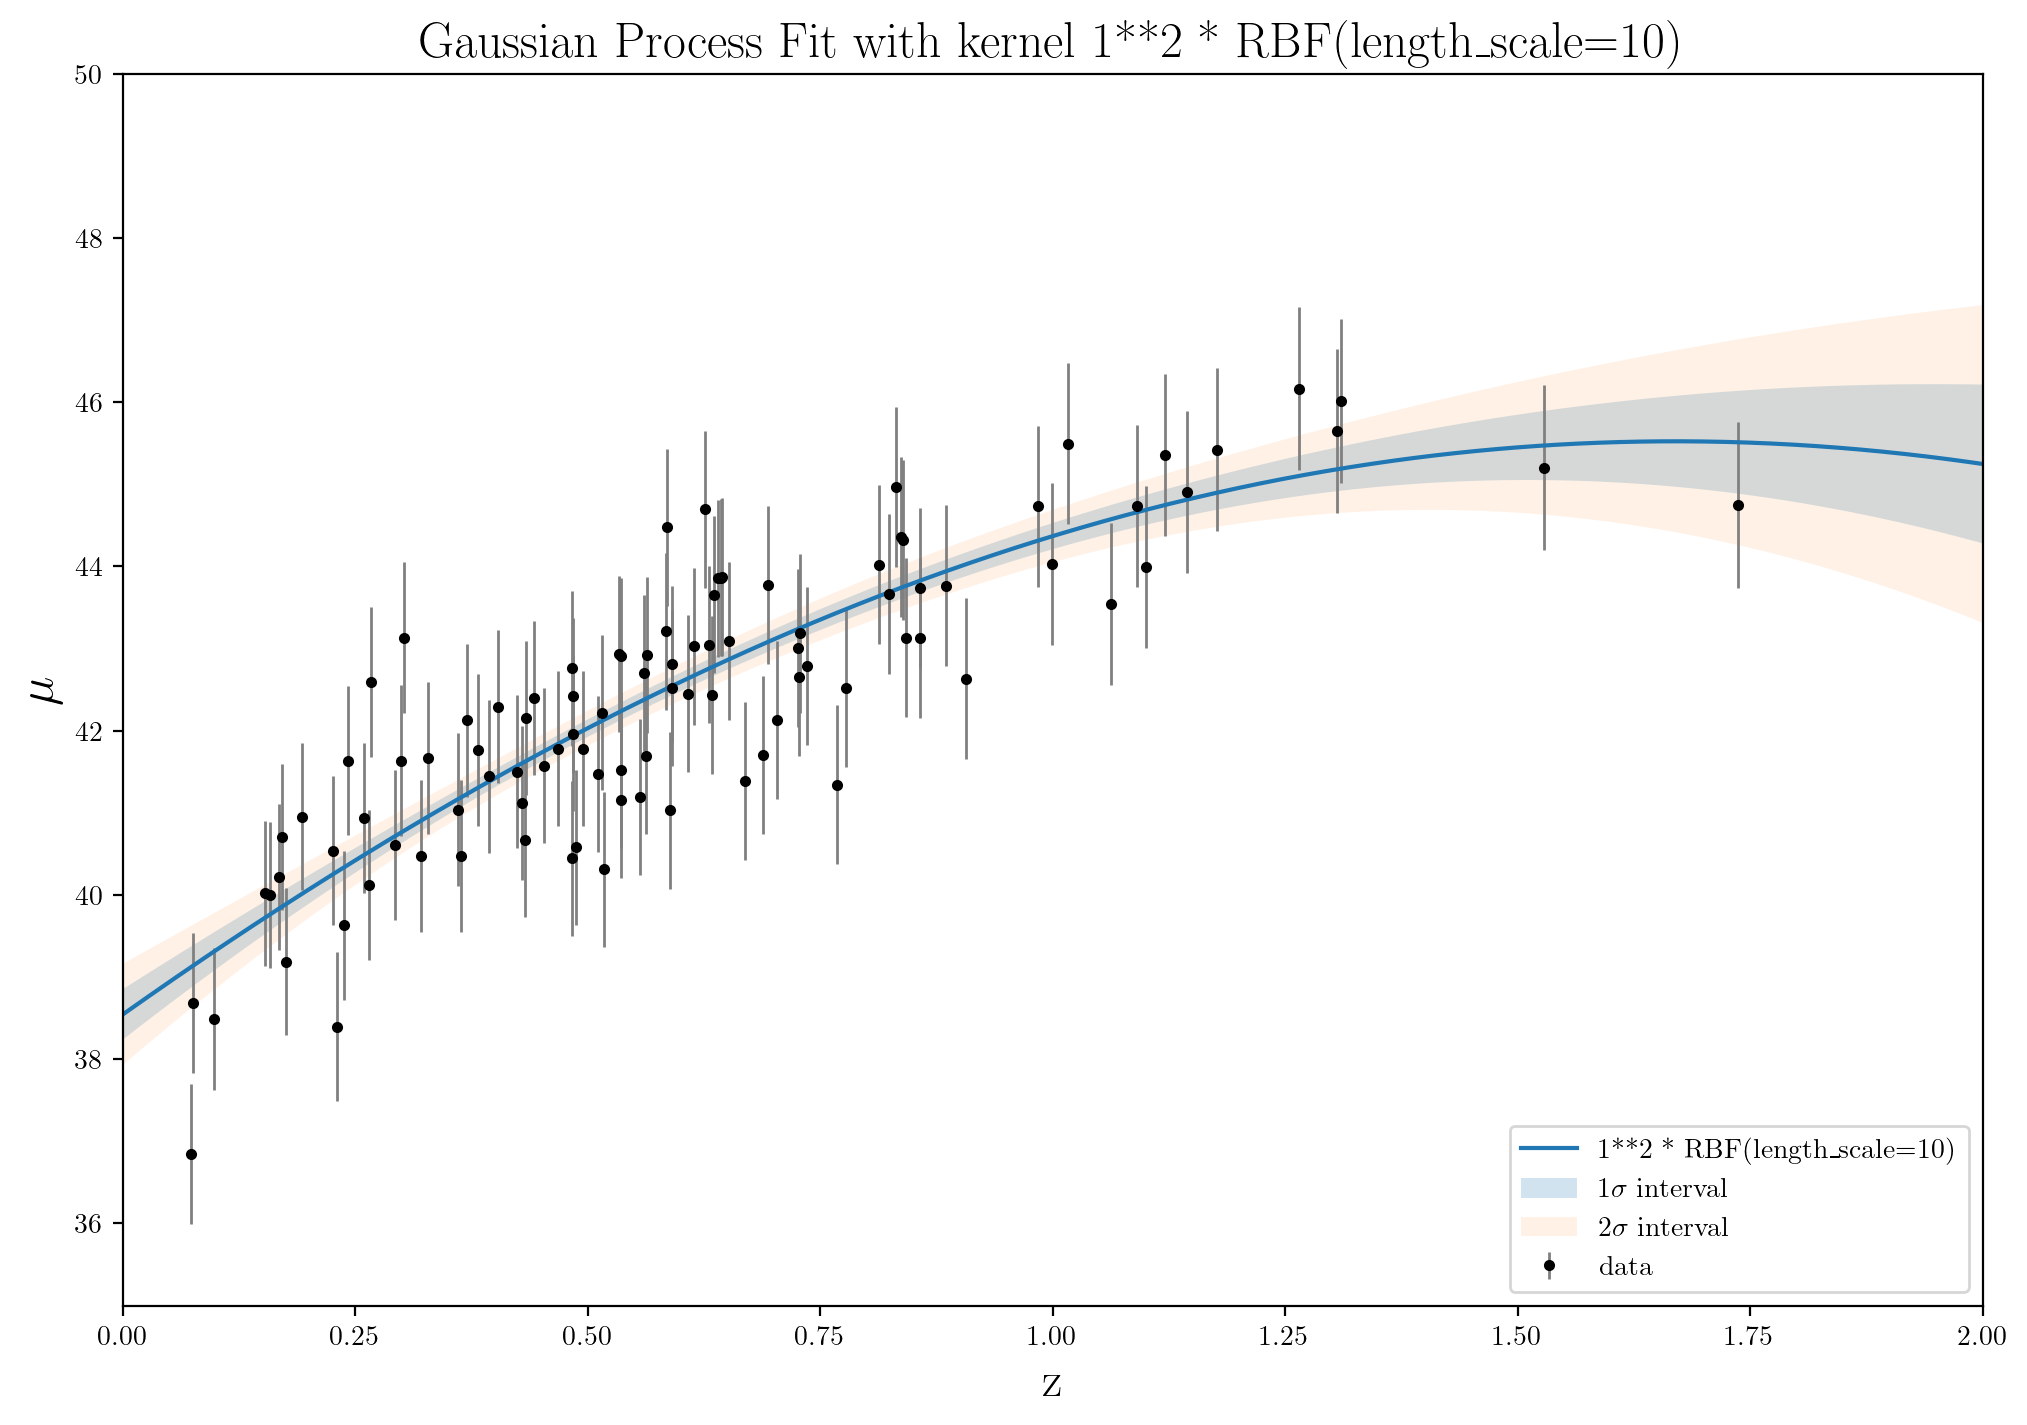

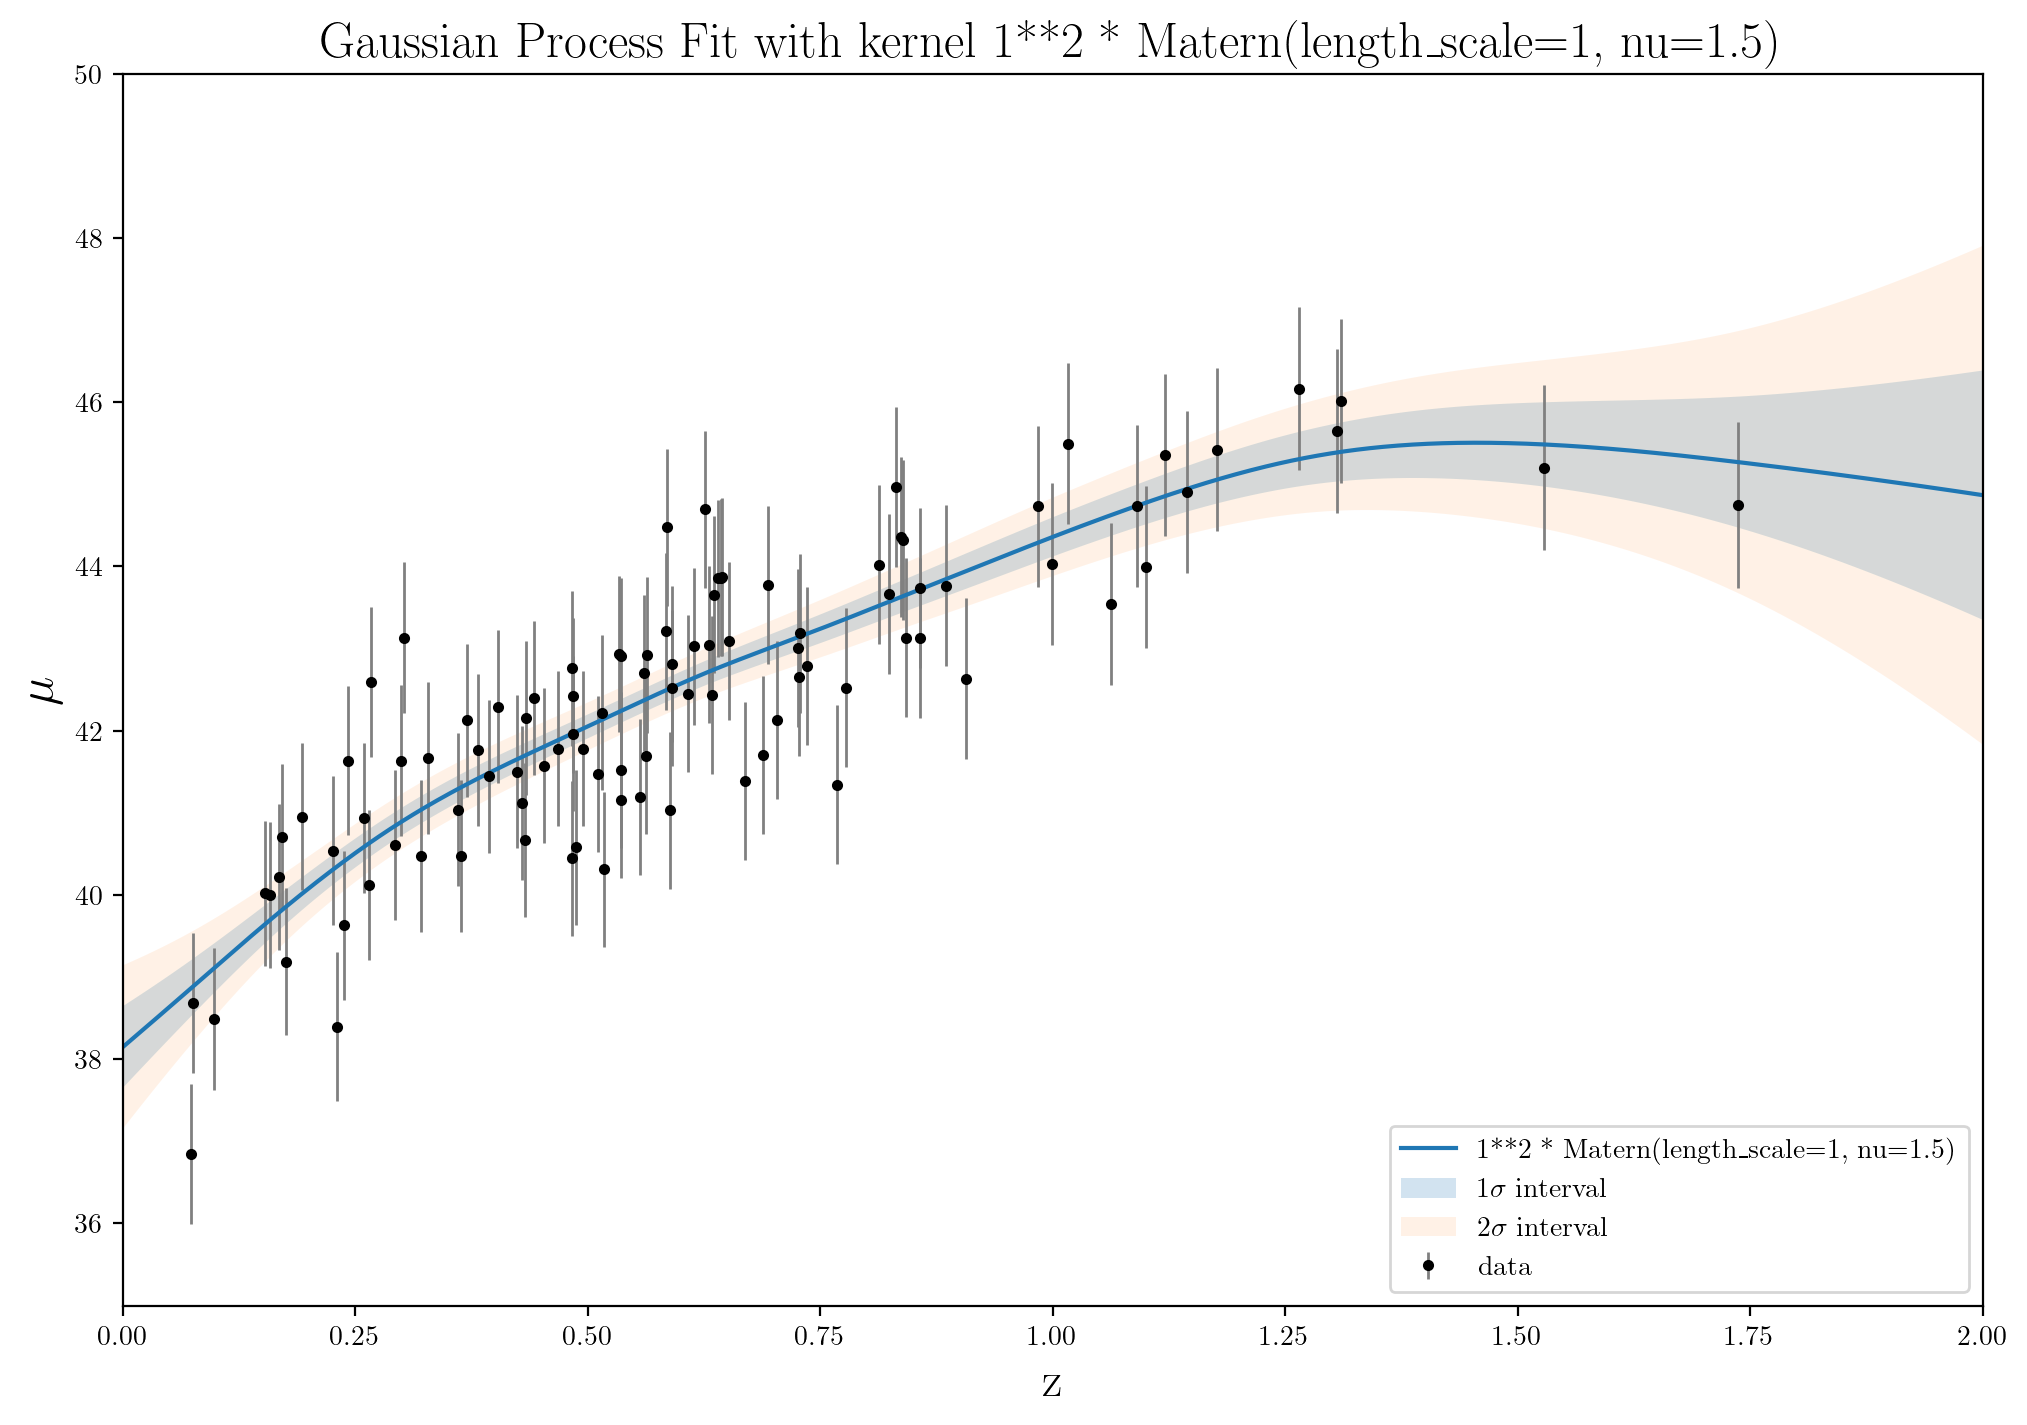

In [14]:
alpha = dmu ** 2 #errors from std to variance to be included in the fit
z_fit = np.linspace(0,2,1000)

kernels = [
    ConstantKernel(1.0) * RBF(length_scale=10),
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
]

plt.figure(figsize=(12, 12))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    gp.fit(z_sample.reshape(-1, 1), mu_sample)
    mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)

    plt.plot(z_fit, mu_pred, label=f'{kernel}')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Gaussian Process Fits', fontsize=18)
plt.show()

for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    gp.fit(z_sample.reshape(-1, 1), mu_sample)
    mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)

    plt.figure(figsize=(12, 8))
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
    plt.plot(z_fit, mu_pred, label=f'{kernel}')
    plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1 $\sigma$ interval')
    plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.1, label='2 $\sigma$ interval')

    plt.xlabel("z",  fontsize=18)
    plt.ylabel("$\mu$",  fontsize=18)
    plt.legend(loc='lower right')
    plt.xlim(0, 2)
    plt.ylim(35, 50)
    plt.title(f'Gaussian Process Fit with kernel {kernel}',  fontsize=18)
    plt.show()

## Split the data in 2 : one test set and the other for train and cross validate

In [72]:
z_t, z_test, mu_t, mu_test, dmu_t, dmu_test = train_test_split(z_sample, mu_sample, dmu, test_size=0.2, random_state=10)

now I will use z_t, mu_t and dmu_t TRAIN to train and cross validate on the single model, then I will use the test set to compare the two best models

### Validation on RBF 

In [73]:
constants = np.geomspace(0.1, 100, 50)
scales = np.linspace(1, 100, 50)

crossval_err = []
kf = KFold(n_splits=5, shuffle=True, random_state=8)

for c in constants:
    for ls in scales:
        fold_errors = []
        
        for train_idx, val_idx in kf.split(z_t):
            z_train, z_val = z_t[train_idx], z_t[val_idx]
            mu_train, mu_val = mu_t[train_idx], mu_t[val_idx]
            dmu_train, dmu_val = dmu_t[train_idx], dmu_t[val_idx]
            
            kernel = ConstantKernel(c) * RBF(length_scale=ls)
            gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
            gp.fit(z_train.reshape(-1, 1), mu_train)
            
            mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
            
            weighted_rmse = np.sqrt(np.mean(((mu_pred - mu_val) / dmu_val) ** 2))
            fold_errors.append(weighted_rmse)
        
        crossval_err.append((c, ls, np.mean(fold_errors)))

best_kernel_params = min(crossval_err, key=lambda x: x[2])
print(f"Best kernel parameters: Constant {best_kernel_params[0]}, Length Scale {best_kernel_params[1]} with error {best_kernel_params[2]:.4f}")


Best kernel parameters: Constant 2.9470517025518097, Length Scale 13.122448979591836 with error 0.9740


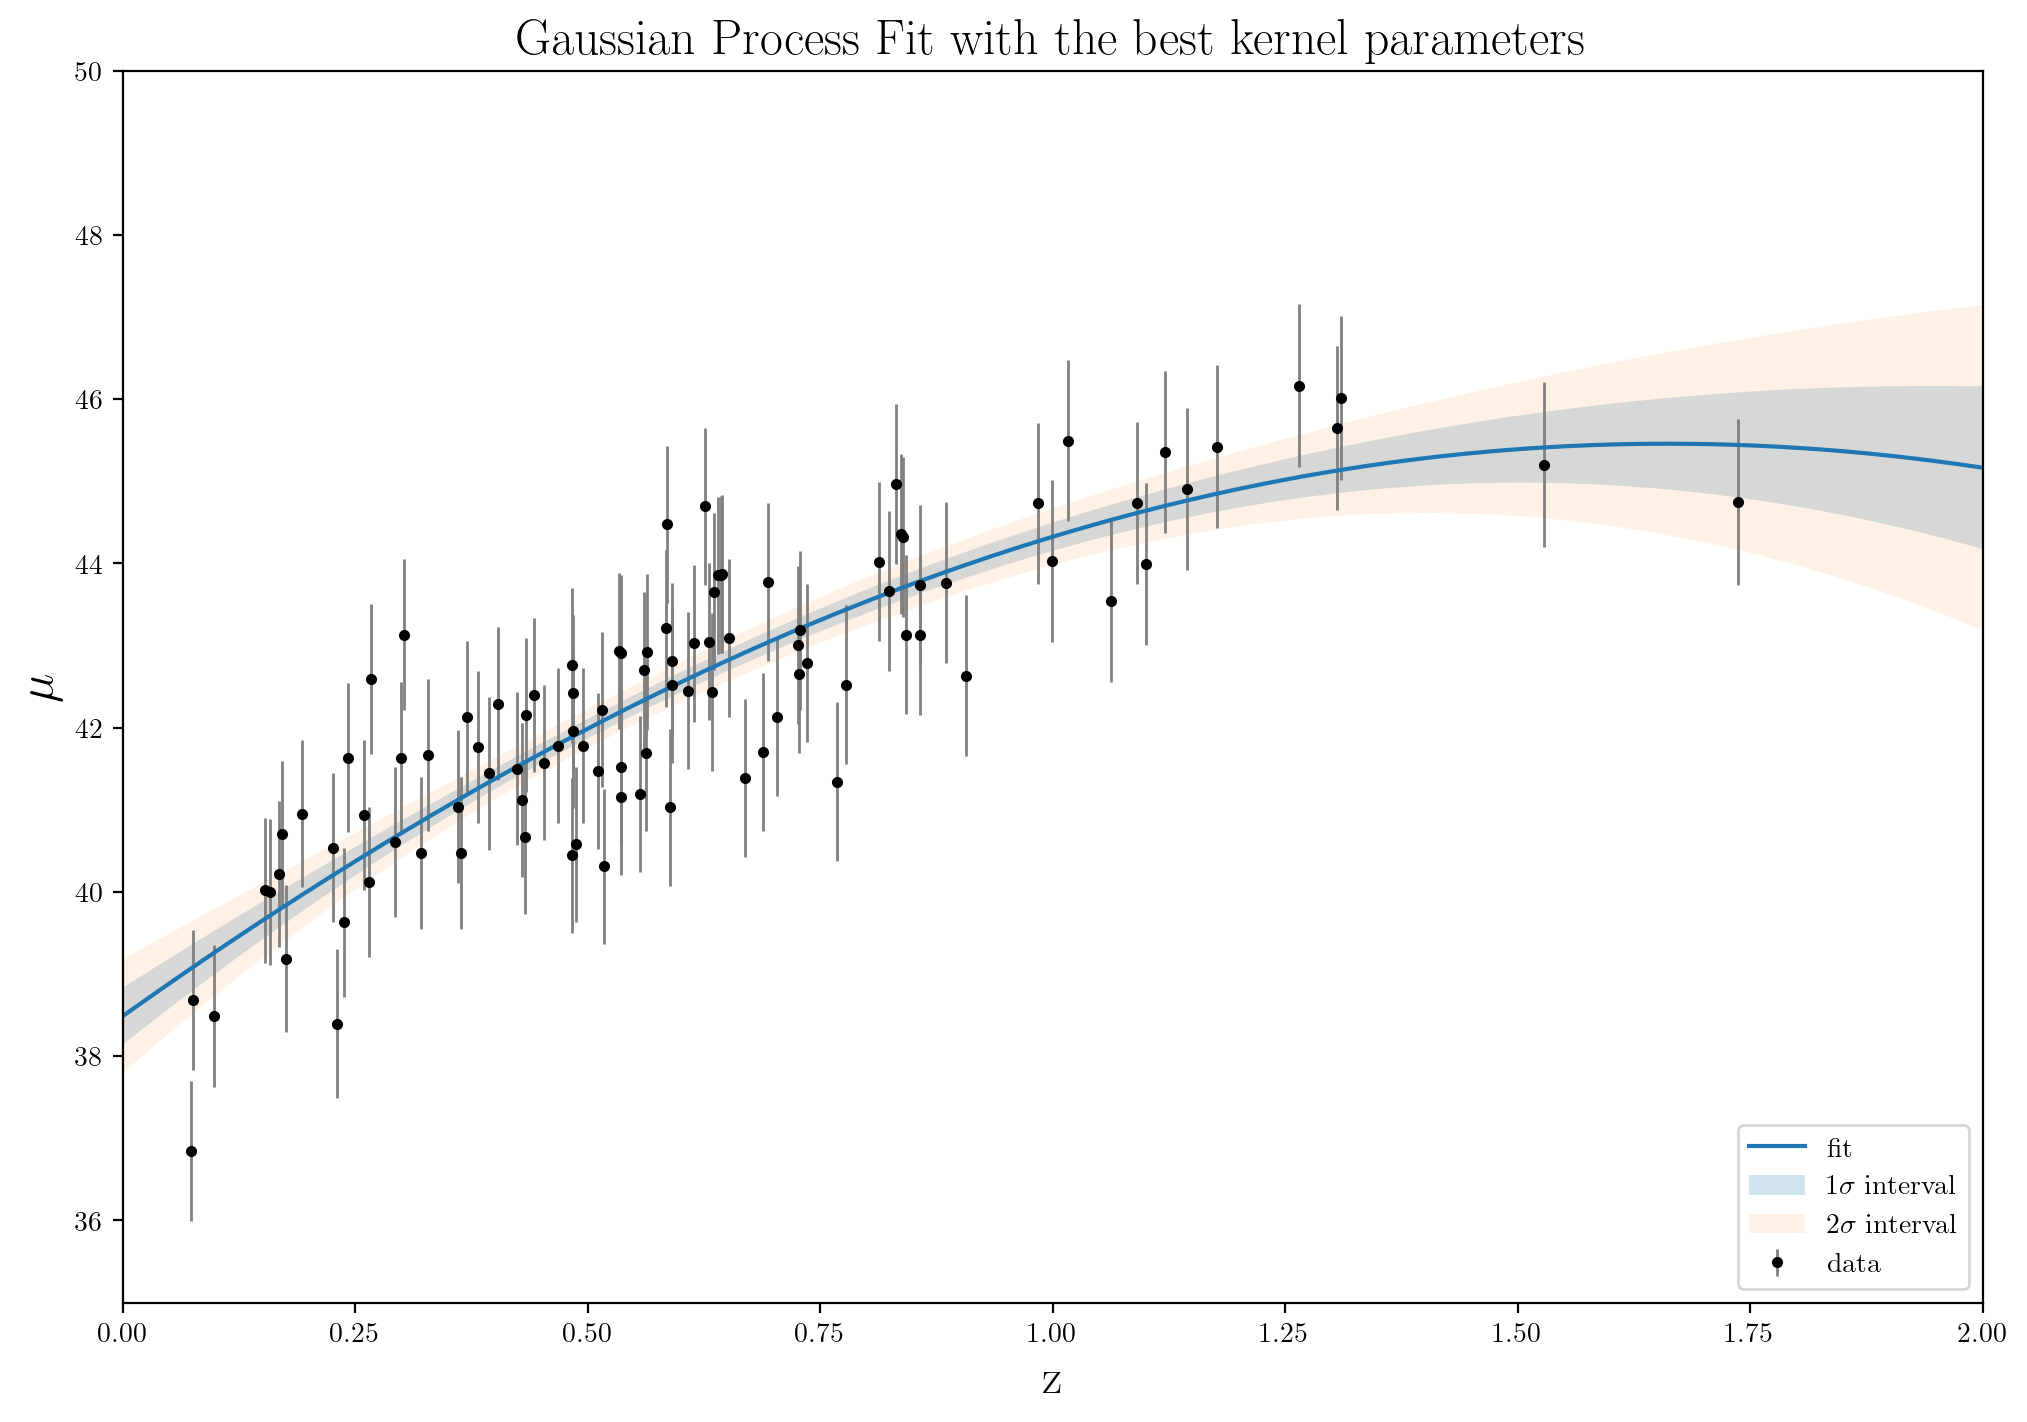

In [81]:
kernel = ConstantKernel(best_kernel_params[0]) * RBF(length_scale=best_kernel_params[1])

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_t**2)
gp.fit(z_t.reshape(-1, 1), mu_t)
mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)


plt.figure(figsize=(12, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_pred, label=f'fit')
plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1$\sigma$ interval')
plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.1, label='2$\sigma$ interval')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(f'Gaussian Process Fit with the best kernel parameters',  fontsize=18)
plt.show()

### K-fold cross validation on Matern

In [75]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
constants = np.geomspace(0.1, 100, 50)
scales = np.linspace(1, 100, 50)
nu = [0.2,1.5,2.5]

crossval_err = []
kf = KFold(n_splits=5, shuffle=True, random_state=8)

for c in constants:
    for ls in scales:
        for n in nu:
                
            fold_errors = []
            
            for train_idx, val_idx in kf.split(z_t):
                z_train, z_val = z_t[train_idx], z_t[val_idx]
                mu_train, mu_val = mu_t[train_idx], mu_t[val_idx]
                dmu_train, dmu_val = dmu_t[train_idx], dmu_t[val_idx]
                
                kernel = ConstantKernel(c) * Matern(length_scale=ls, nu=n)
                gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
                gp.fit(z_train.reshape(-1, 1), mu_train)
                
                mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
                
                weighted_rmse = np.sqrt(np.mean(((mu_pred - mu_val) / dmu_val) ** 2))
                fold_errors.append(weighted_rmse)
            
            crossval_err.append((c, ls, np.mean(fold_errors)))

best_kernel_params_2 = min(crossval_err, key=lambda x: x[2])
print(f"Best kernel parameters: Constant {best_kernel_params_2[0]}, Length Scale {best_kernel_params_2[1]} , Nu {best_kernel_params_2[2]:.4f}")


Best kernel parameters: Constant 12.067926406393289, Length Scale 85.85714285714285 , Nu 0.9700


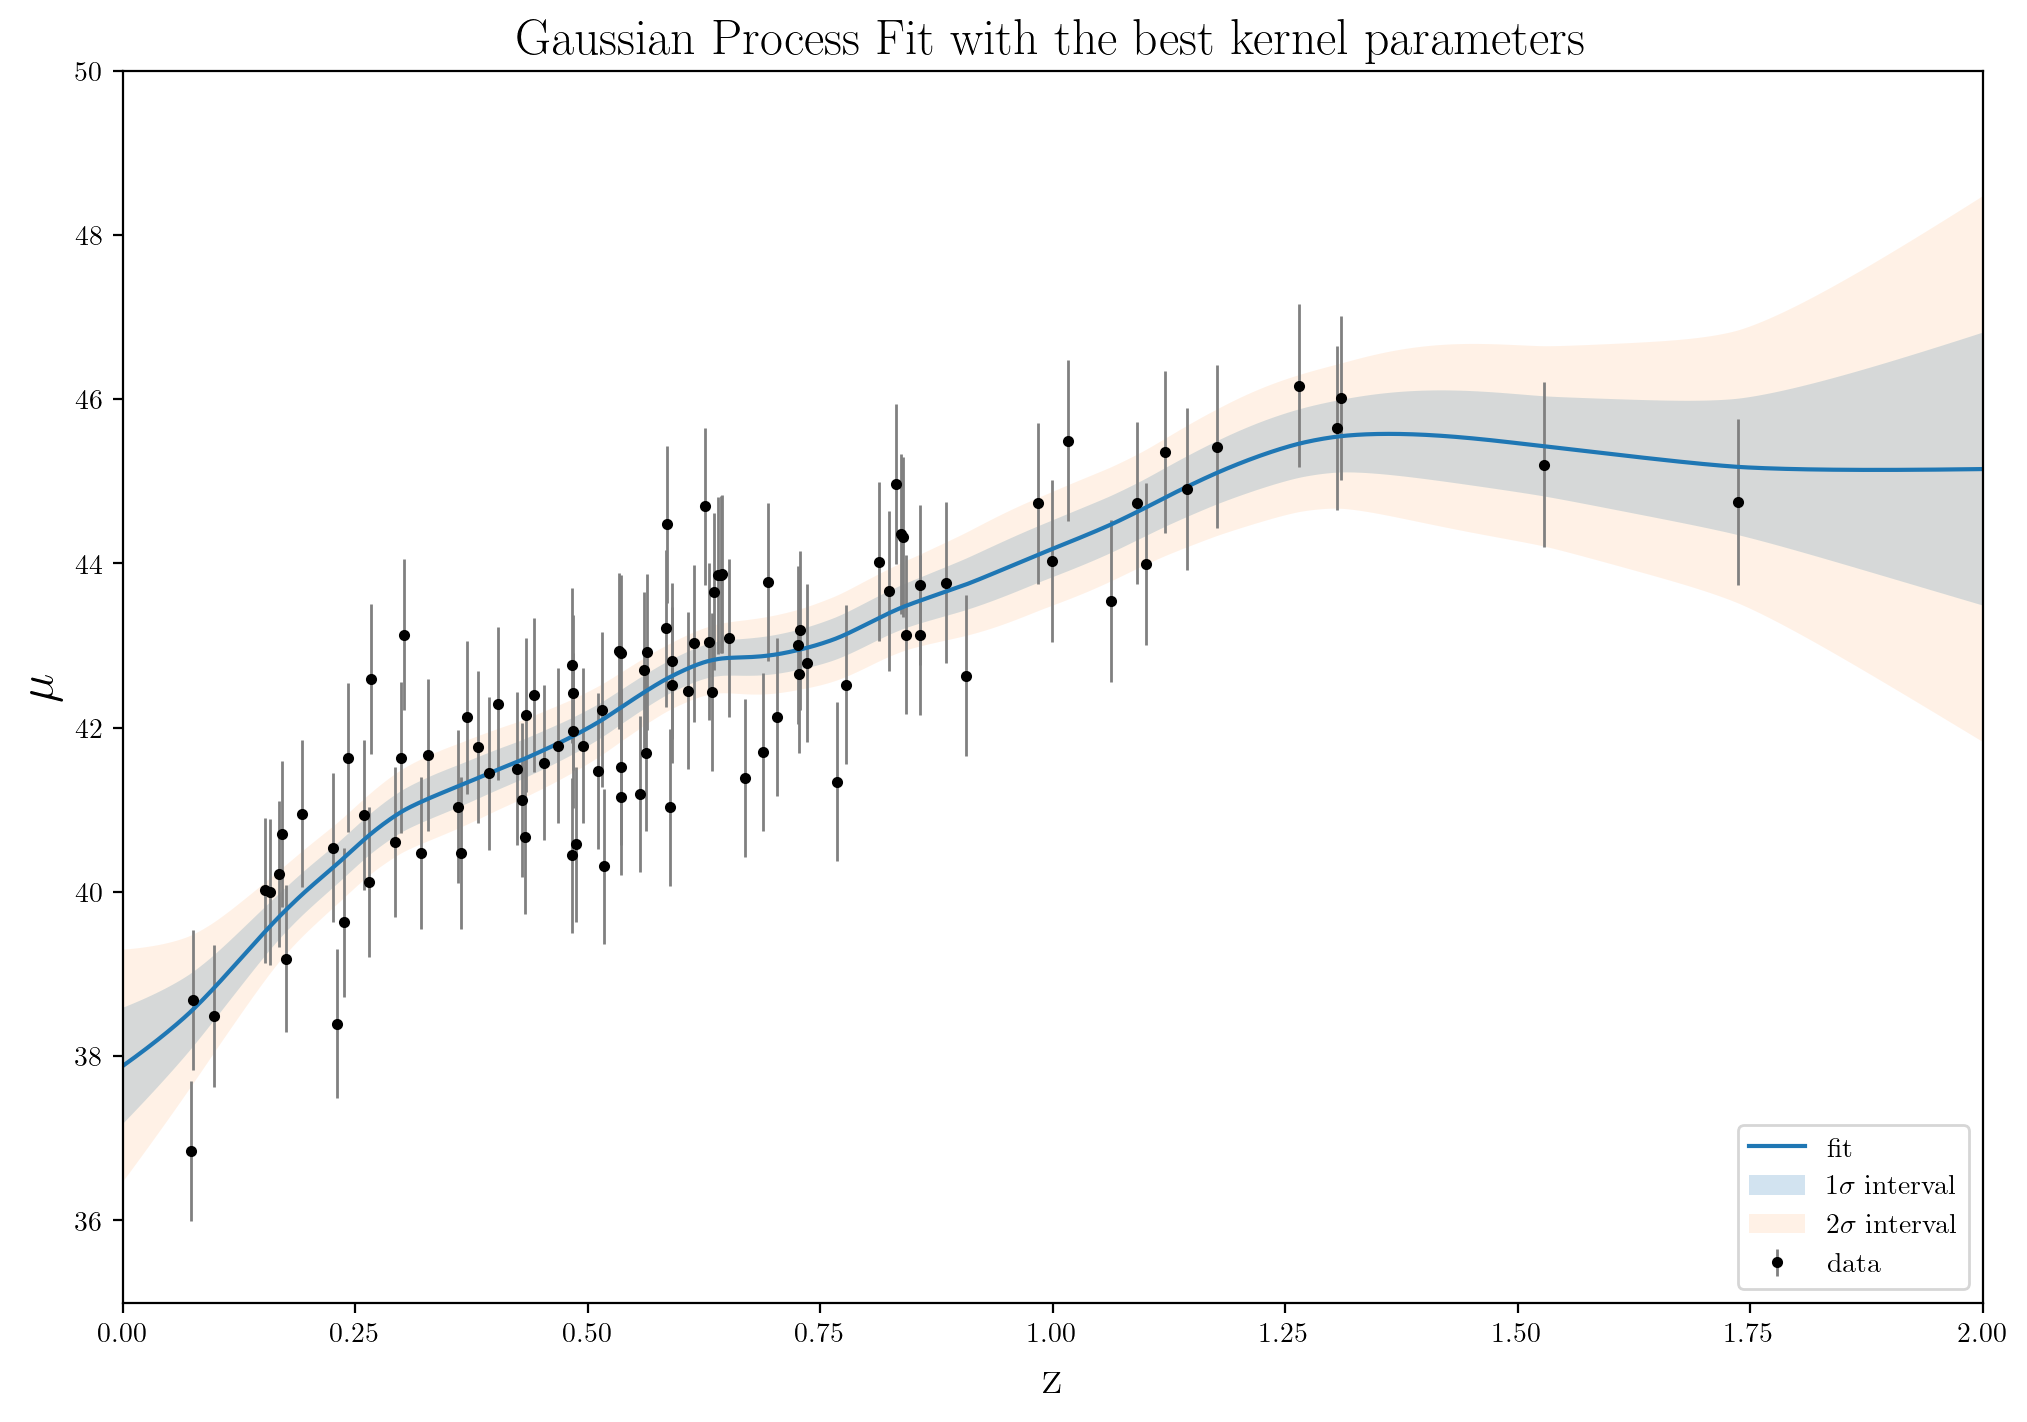

In [77]:
kernel = ConstantKernel(best_kernel_params_2[0]) * Matern(length_scale=best_kernel_params_2[1], nu=best_kernel_params_2[2])

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_t**2)
gp.fit(z_t.reshape(-1, 1), mu_t)
mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)


plt.figure(figsize=(12, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_pred, label=f'fit')
plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1$\sigma$ interval')
plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.1, label='2$\sigma$ interval')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(f'Gaussian Process Fit with the best kernel parameters',  fontsize=18)
plt.show()

## Comparison between the two best - DA CAMBIARE

In [80]:
from sklearn.metrics import mean_squared_error

kernel1 = ConstantKernel(best_kernel_params[0]) * RBF(length_scale=best_kernel_params[1])
model1 = GaussianProcessRegressor(kernel=kernel1, alpha=dmu_test**2)

kernel2 = ConstantKernel(best_kernel_params_2[0]) * Matern(length_scale=best_kernel_params_2[1], nu=best_kernel_params_2[2])
model2 = GaussianProcessRegressor(kernel=kernel2, alpha=dmu_test**2)

mu_pred_model1, mu_std_model1 = model1.predict(z_test.reshape(-1, 1), return_std=True)
mu_pred_model2, mu_std_model2 = model2.predict(z_test.reshape(-1, 1), return_std=True)

rmse_model1 = np.sqrt(mean_squared_error(mu_test, mu_pred_model1))
rmse_model2 = np.sqrt(mean_squared_error(mu_test, mu_pred_model2))

weighted_rmse_model1 = np.sqrt(np.mean(((mu_pred_model1 - mu_test) / dmu_test) ** 2))
weighted_rmse_model2 = np.sqrt(np.mean(((mu_pred_model2 - mu_test) / dmu_test) ** 2))

nll_model1 = 0.5 * np.sum(((mu_pred_model1 - mu_test) / mu_std_model1) ** 2 + np.log(mu_std_model1 ** 2))
nll_model2 = 0.5 * np.sum(((mu_pred_model2 - mu_test) / mu_std_model2) ** 2 + np.log(mu_std_model2 ** 2))

print(f"Test RMSE Model 1: {rmse_model1:.4f}")
print(f"Test Weighted RMSE Model 1: {weighted_rmse_model1:.4f}")
print(f"Test NLL Model 1: {nll_model1:.4f}")

print(f"Test RMSE Model 2: {rmse_model2:.4f}")
print(f"Test Weighted RMSE Model 2: {weighted_rmse_model2:.4f}")
print(f"Test NLL Model 2: {nll_model2:.4f}")

Test RMSE Model 1: 42.2088
Test Weighted RMSE Model 1: 44.8854
Test NLL Model 1: 6056.1178
Test RMSE Model 2: 42.2088
Test Weighted RMSE Model 2: 44.8854
Test NLL Model 2: 1501.2022


# Parametric Fit
- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

#### My computation
Let's assume curvature equal 0, so $\Omega_K$ = 0
1. $$\mu = 5 \log \left(\frac{D_L}{10pc}\right) $$

2. $$ D_L = (1+z)D_C $$

3. $$  D_C = c/H_0 \int _0 ^z \frac{dz'}{E(z')} = c/H_0 \int _0 ^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3+\Omega_\Lambda}}$$

4. $$ \Omega_\Lambda = 1 - \Omega_m  $$

so the 1st equation become 
$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z')^3+(1-\Omega_m)}} \right) $$



In [62]:
def mu(z, H0, om):
    def integrand(z_prime):
        return 1.0 / np.sqrt(om * (1 + z_prime)**3 + (1 - om))
    
    integrals = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    
    # Convert H0 from km/s/Mpc to s^-1 for consistency with c
    H0_in_s = H0 * 1000 / 3.086e19  # H0 in s^-1
    distance = (c.c.value / H0_in_s) * (10**3) * (1 + z) * integrals  # in pc
    mu_value = 5 * np.log10(distance / 10)  # magnitude
    
    return mu_value

Optimal parameters are $H_0$=8252424383181.957, $\Omega_m$=%207370807954.5739


/tmp/ipykernel_7914/4230929414.py:10: RuntimeWarning: divide by zero encountered in log10
  mu_value = 5 * np.log10(distance / 10)  # magnitude


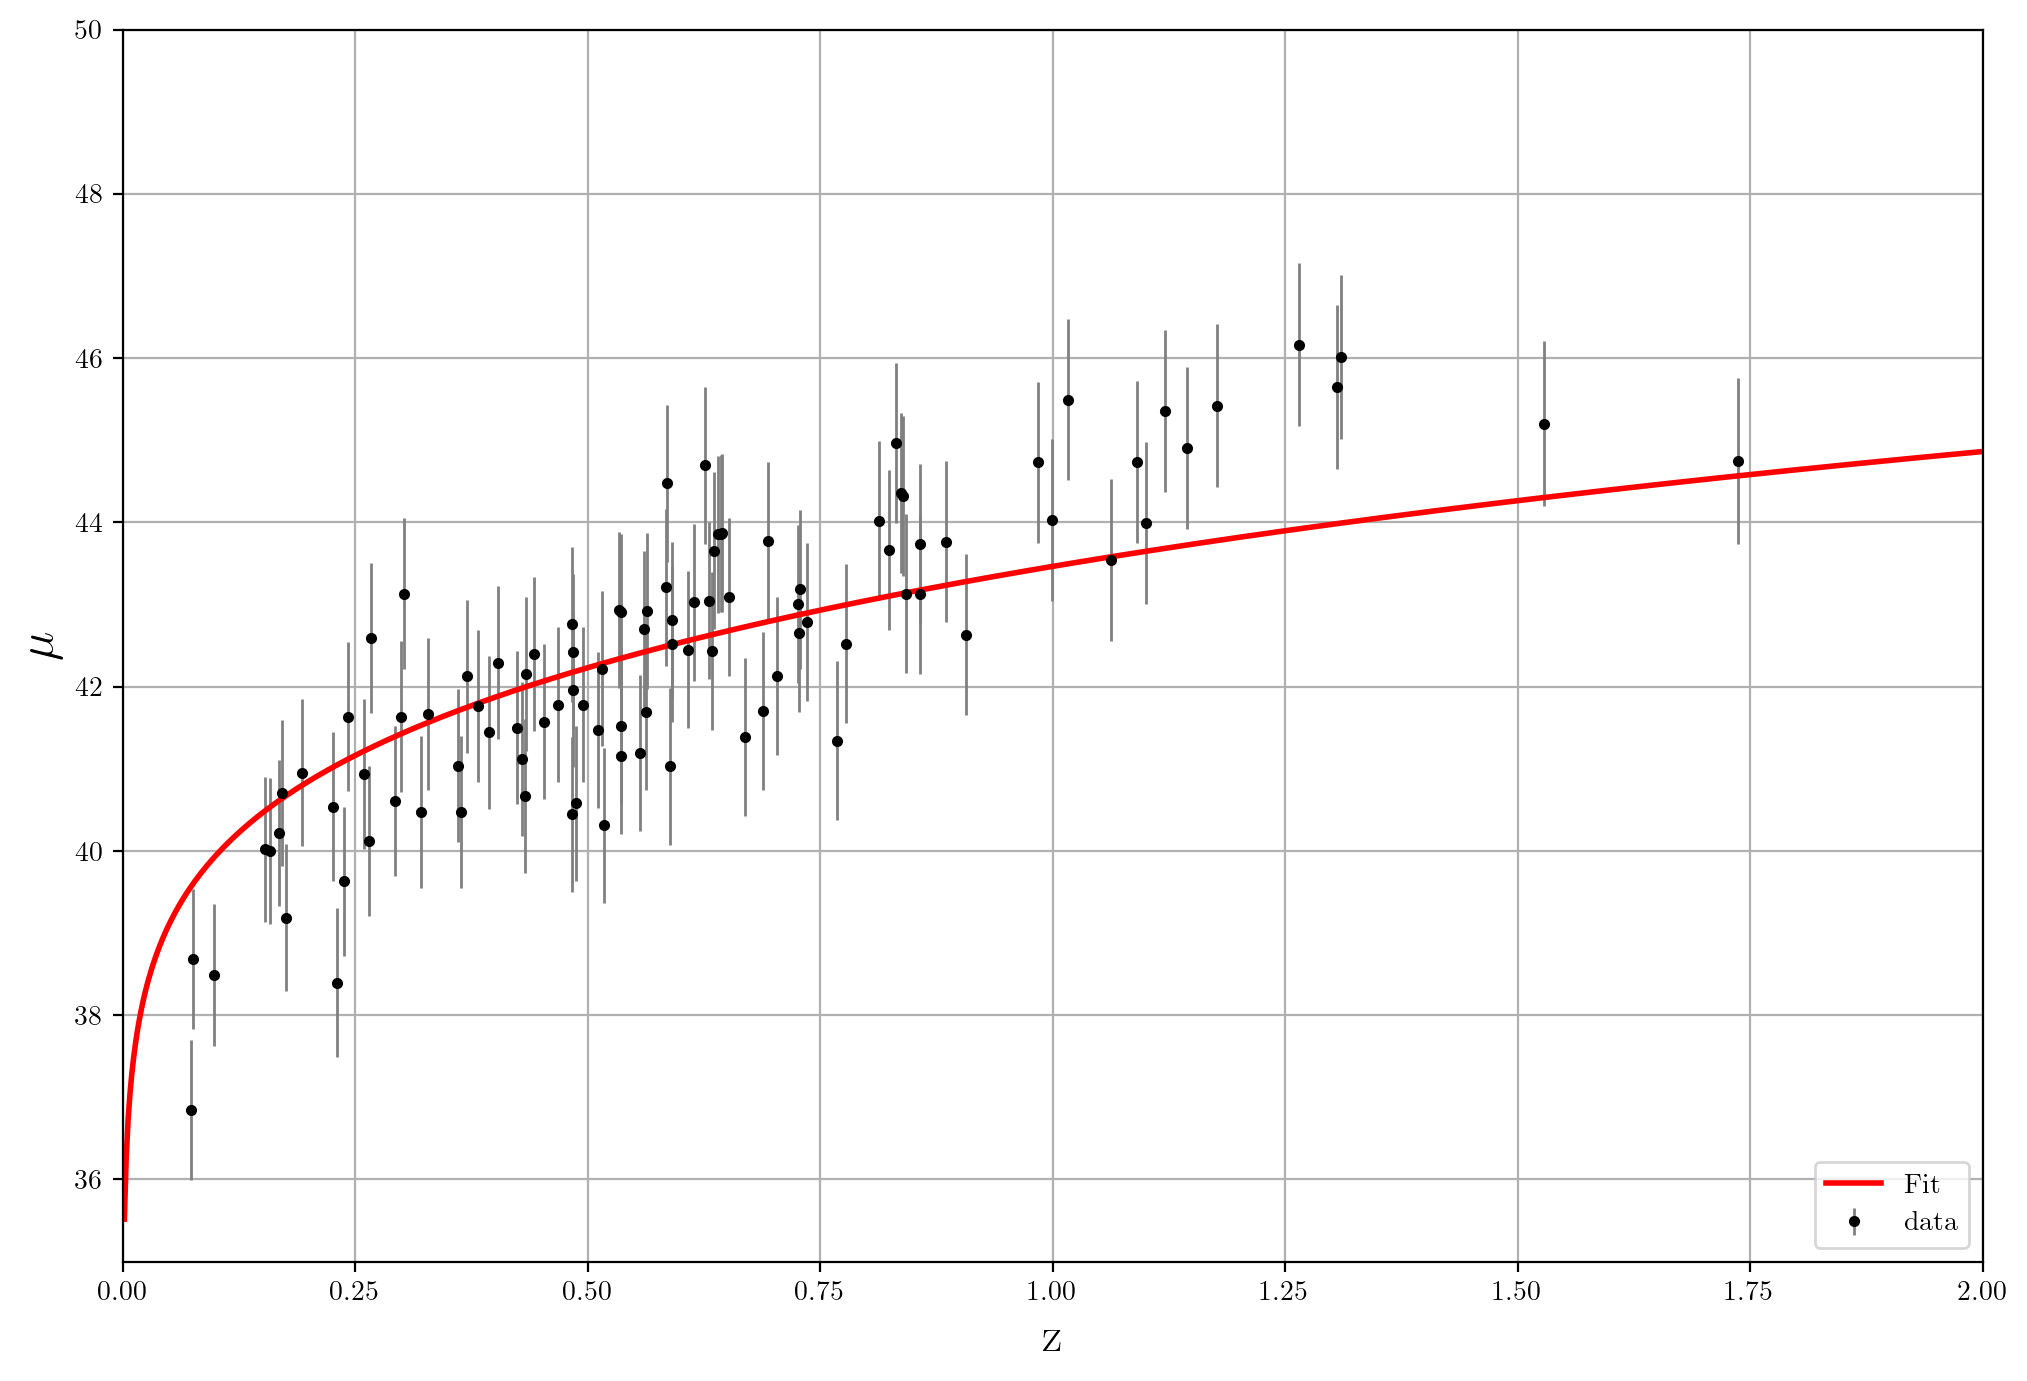

In [63]:
popt, pcov = curve_fit(mu, z_sample, mu_sample, sigma=dmu, p0=(67,0.8))
H0, omega = popt
print(f'Optimal parameters are $H_0$={H0}, $\Omega_m$=%{omega}')

mu_fit = mu(z_fit, *popt) 

plt.figure(figsize=(12, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_fit, 'r-', label='Fit', lw=2) 
plt.xlabel("z", fontsize=18)
plt.ylabel("$\mu$", fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.grid(True)
plt.show()